In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials 


# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

from scipy.signal import savgol_filter

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### Cargar datasets

In [2]:
#df_af = pd.read_pickle('audio_features.pickle')
#df_tracks = pd.read_pickle('tracks.pickle')
df_aa = pd.read_pickle('audio_analysis.pickle') \
    .set_index(['id','start']) \
    .sort_values(by=['id', 'start'], ascending=True, na_position='first')

### Contenido de los datasets

In [3]:
df_aa.head(3).T

id                                            00At7PWydsvg7g5xgaYan9  \
start                                                        0.00000   
duration                                                     0.24381   
confidence                                                         0   
loudness_start                                                   -60   
loudness_max_time                                                  0   
loudness_max                                                     -60   
loudness_end                                                       0   
pitches            [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
timbre             [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...   

id                                                                    \
start                                                        0.24381   
duration                                                     0.17492   
confidence                                                         1   
loudness_start                                                   -60   
loudness_max_time                                            0.01436   
loudness_max                                                 -12.457   
loudness_end                                                       0   
pitches            [0.121, 0.996, 0.08, 0.104, 1.0, 0.223, 0.043,...   
timbre             [37.641, -77.643, -30.613, 137.462, 36.96, -51...   

id                                                                    
start                                                        0.41873  
duration                                                     0.17329  
confidence                                                         1  
loudness_start                                               -34.279  
loudness_max_time                                            0.01554  
loudness_max                                                 -12.728  
loudness_end                                                       0  
pitches            [0.032, 1.0, 0.06, 0.059, 0.368, 0.084, 0.036,...  
timbre             [38.171, -17.741, -22.798, 149.223, 31.833, -5...

### Sampleo para una canción
Elegimos dos canciones en particular y apuntamos a procesar sus series temporales

In [4]:
s1 = df_aa.xs('3AHm9YdMDhM9PKFqkHmb98',level='id').sort_index()
s2 = df_aa.xs('0ygAYQQy7bfDN6gH640bbl',level='id').sort_index()
s1.head(3).T

start,0.00000,0.53179,0.79619
duration,0.53179,0.2644,0.18317
confidence,0,0.316,0.089
loudness_start,-46.357,-42.892,-43.631
loudness_max_time,0.31587,0.03835,0.0555
loudness_max,-41.528,-40.825,-41.749
loudness_end,0,0,0
pitches,"[0.009, 0.05, 0.596, 0.078, 0.012, 0.006, 0.05...","[0.044, 0.258, 1.0, 0.136, 0.011, 0.016, 0.079...","[0.119, 0.659, 1.0, 0.209, 0.067, 0.107, 0.164..."
timbre,"[17.014, -113.596, -87.608, -74.463, 17.327, -...","[18.274, -98.857, -52.96, -36.019, -8.931, -44...","[17.445, -86.49, -21.866, -33.274, 11.488, -43..."


In [5]:
(len(s1),len(s2))

(639, 636)

### Pasaje de las listas de datos (pitches y timbre) a columnas

Esto es para simplificar el procesamiento y ver cómo evolucionan los datos en el tiempo.

In [16]:
df_m2 = s1
pitches_nombre = ['p00_C','p01_C#','p02_D','p03_D#','p04_E','p05_F',
                 'p06_F#','p07_G','p08_G#','p09_A','p10_A#','p11_B']
timbre_nombre = ['t00','t01','t02','t03','t04','t05',
                 't06','t07','t08','t09','t10','t11']

def turn_to_cols(df):
    df1 = pd.DataFrame(df['pitches'].tolist(), columns=pitches_nombre, index=df.index)
    df = pd.concat([df,df1],axis=1)

    df1 = pd.DataFrame(df['timbre'].tolist(), columns=timbre_nombre, index=df.index)
    return pd.concat([df,df1],axis=1)

s1 = turn_to_cols(s1)
s2 = turn_to_cols(s2)
s1.head(3).T

start,0.00000,0.53179,0.79619
duration,0.53179,0.2644,0.18317
confidence,0,0.316,0.089
loudness_start,-46.357,-42.892,-43.631
loudness_max_time,0.31587,0.03835,0.0555
loudness_max,-41.528,-40.825,-41.749
loudness_end,0,0,0
pitches,"[0.009, 0.05, 0.596, 0.078, 0.012, 0.006, 0.05...","[0.044, 0.258, 1.0, 0.136, 0.011, 0.016, 0.079...","[0.119, 0.659, 1.0, 0.209, 0.067, 0.107, 0.164..."
timbre,"[17.014, -113.596, -87.608, -74.463, 17.327, -...","[18.274, -98.857, -52.96, -36.019, -8.931, -44...","[17.445, -86.49, -21.866, -33.274, 11.488, -43..."
p00_C,0.009,0.044,0.119
p01_C#,0.05,0.258,0.659


In [7]:
s1.columns

Index(['duration', 'confidence', 'loudness_start', 'loudness_max_time',
       'loudness_max', 'loudness_end', 'pitches', 'timbre', 'p00_C', 'p01_C#',
       'p02_D', 'p03_D#', 'p04_E', 'p05_F', 'p06_F#', 'p07_G', 'p08_G#',
       'p09_A', 'p10_A#', 'p11_B', 't00', 't01', 't02', 't03', 't04', 't05',
       't06', 't07', 't08', 't09', 't10', 't11'],
      dtype='object')

## GRÁFICOS

Para el suavizado de las series temporales, estamos usando el filtro de Savizky-Golay.

Es para suprimir de una manera rápida el ruido sobre las series.

Y después está la función dynamic time warping que hace una comparación entre las dos series y lo grafica.
https://databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html

Todavía no lo tenemos bien estudiado lo del DTW, pero podría ser un camino para encontrar similaridades o diferencias entre las distintas canciones y rescatar patrones.


In [8]:
def smooth_df(s1,s2,var='confidence'):
    plt.plot(s1.index,s1[var], alpha=0.2)
    plt.plot(s2.index,s2[var], alpha=0.2)

    q = savgol_filter(s1[var], window_length = 101, polyorder = 3)
    new_idx = np.arange(min(s1.index),max(s1.index),1)
    df1 = pd.Series(q,index=s1.index).reindex(new_idx,method='nearest')
    df1.plot()
    q = savgol_filter(s2[var], window_length = 101, polyorder = 3)
    new_idx = np.arange(min(s2.index),max(s2.index),1)
    df2 = pd.Series(q,index=s2.index).reindex(new_idx,method='nearest')
    df2.plot()
    return df1,df2

In [9]:
import numpy as np
from dtw import *

def dynamic_time_warping(d1,d2):
    query = d1.values
    template = d2.values

    ## Find the best match with the canonical recursion formula
    alignment = dtw(query, template, keep_internals=True)

    ## Display the warping curve, i.e. the alignment curve
    alignment.plot(type="threeway")

    ## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
    dtw(query, template, keep_internals=True, 
        step_pattern=rabinerJuangStepPattern(6, "c"))\
        .plot(type="twoway",offset=-2)

    ## See the recursion relation, as formula and diagram
    print(rabinerJuangStepPattern(6,"c"))
    rabinerJuangStepPattern(6,"c").plot()



Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



#### Confidence

The confidence, from 0.0 to 1.0, of the reliability of the segmentation. Segments of the song which are difficult to logically segment (e.g: noise) may correspond to low values in this field.


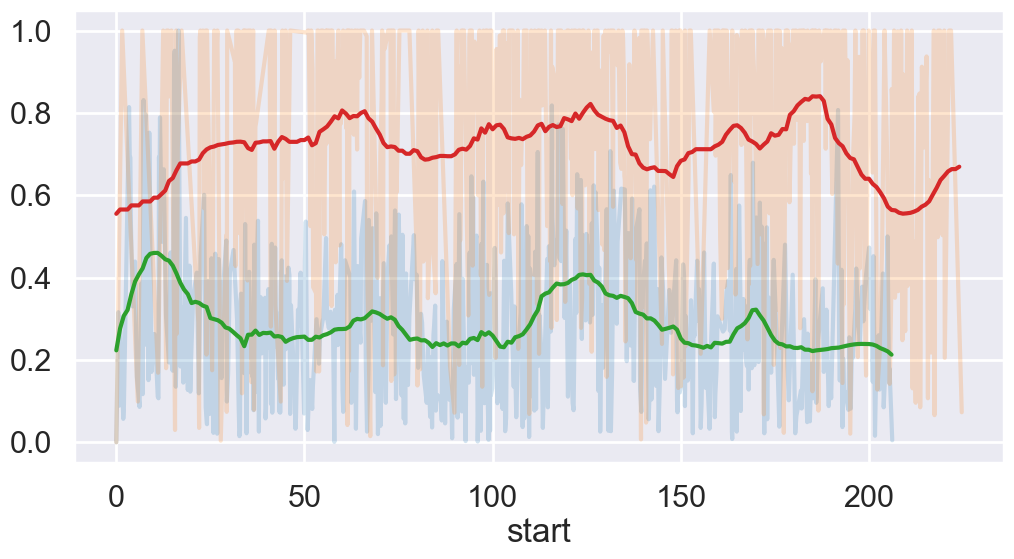

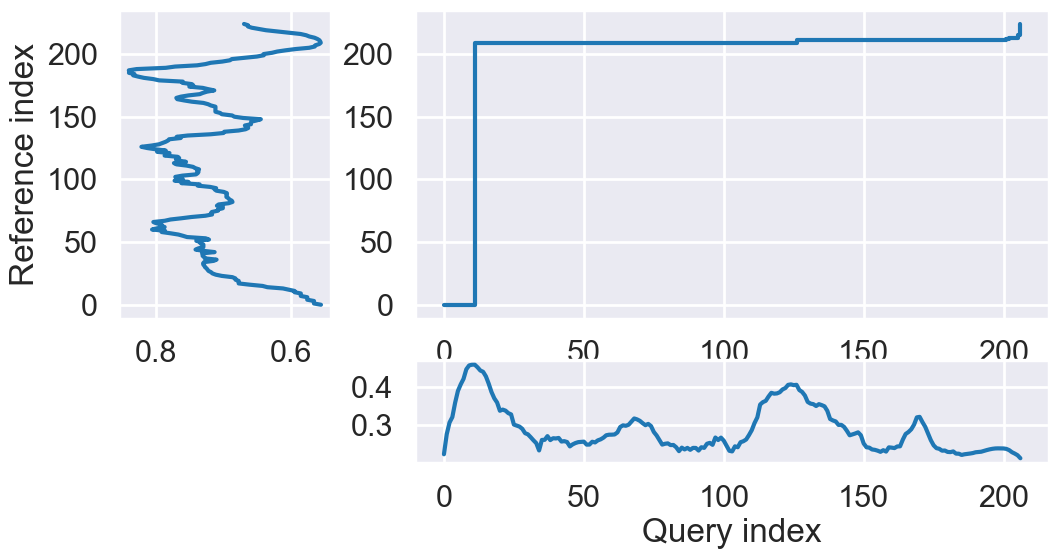

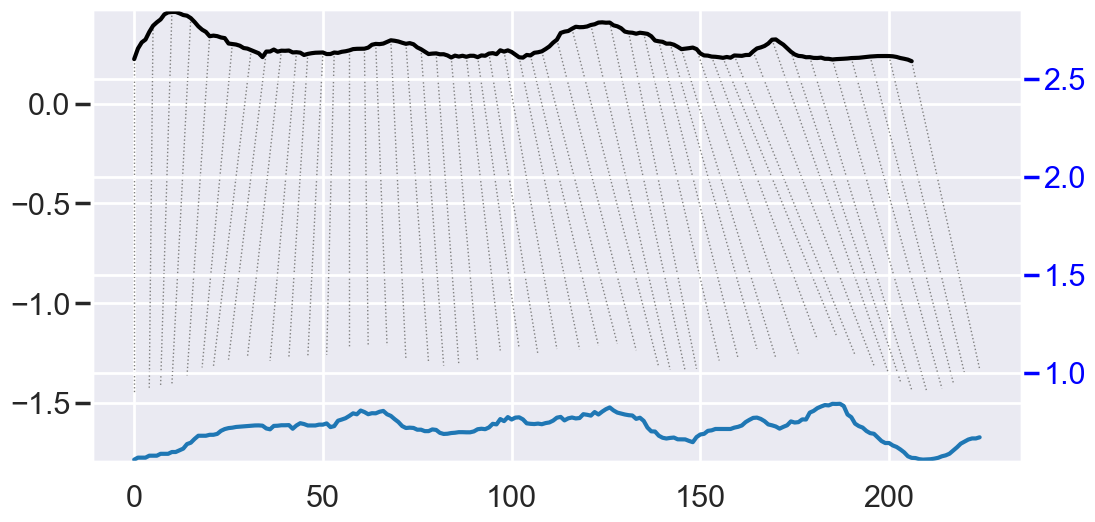

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



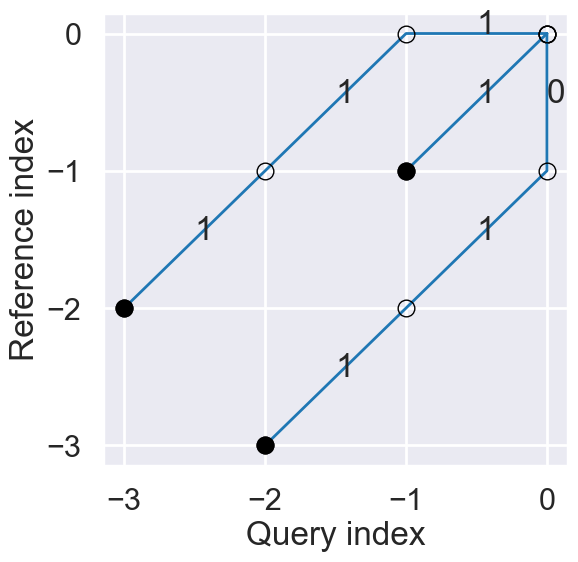

In [10]:
plt.figure()
d1,d2 = smooth_df(s1,s2,var='confidence')
dynamic_time_warping(d1,d2)

#### Loudness_start

The onset loudness of the segment in decibels (dB). Combined with loudness_max and loudness_max_time, these components can be used to describe the “attack” of the segment.

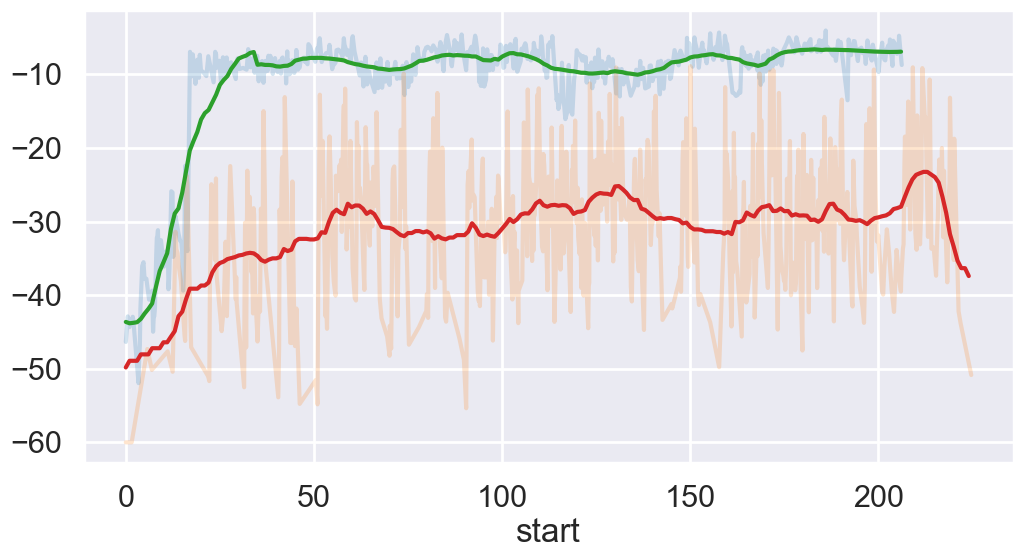

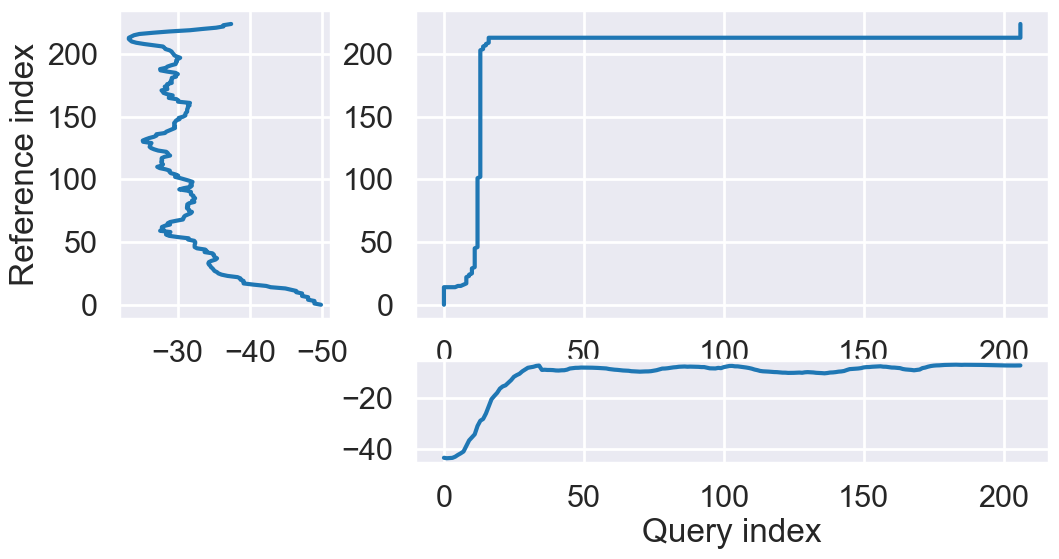

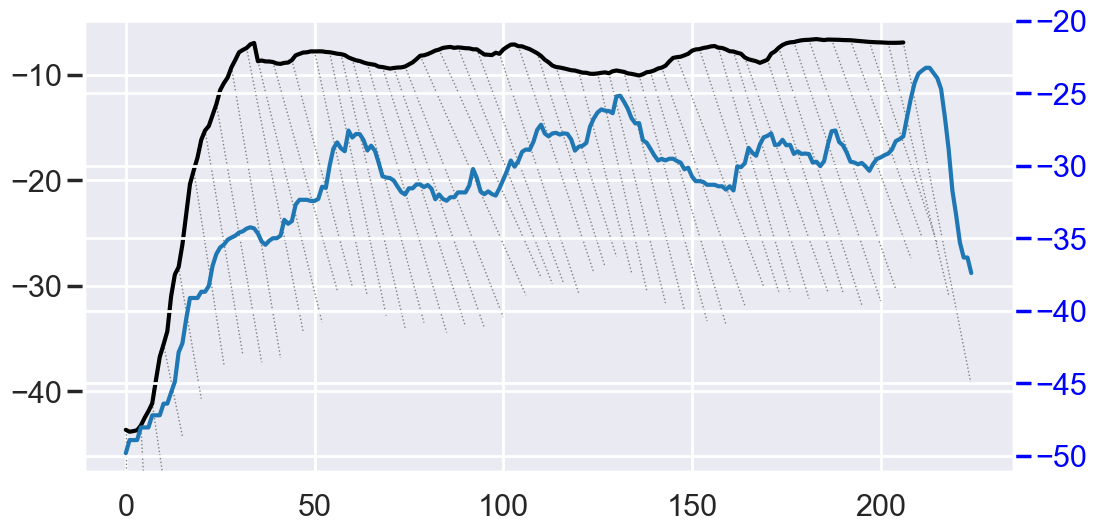

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



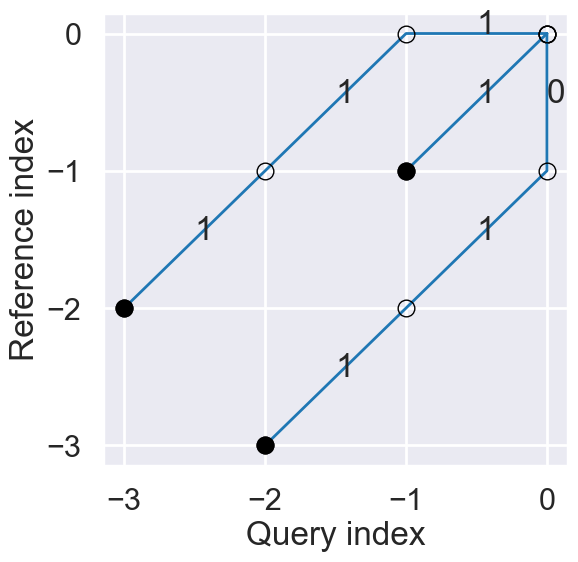

In [11]:

plt.figure()
d1,d2 = smooth_df(s1,s2,var='loudness_start')
dynamic_time_warping(d1,d2)

#### Loudness_max

The peak loudness of the segment in decibels (dB). Combined with loudness_start and loudness_max_time, these components can be used to describe the “attack” of the segment.


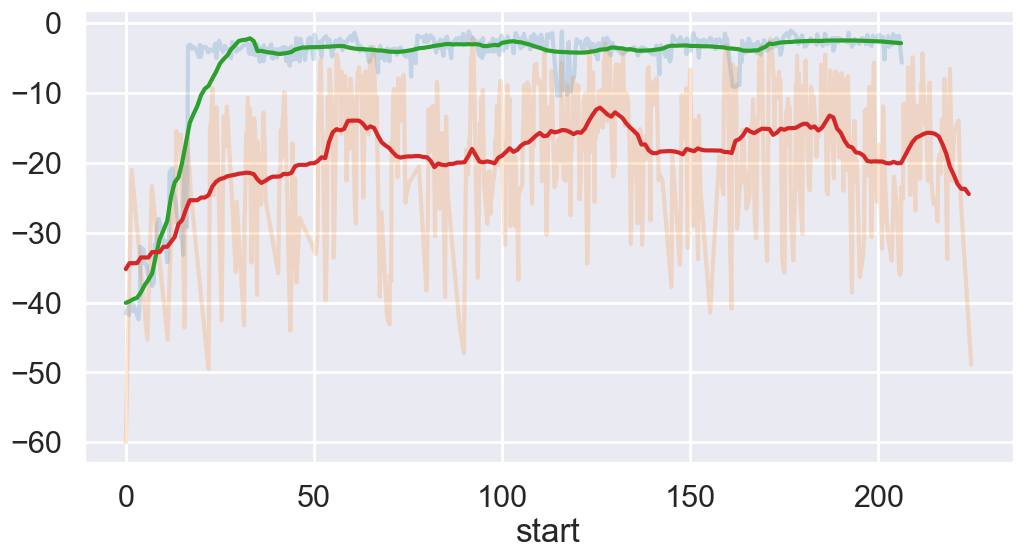

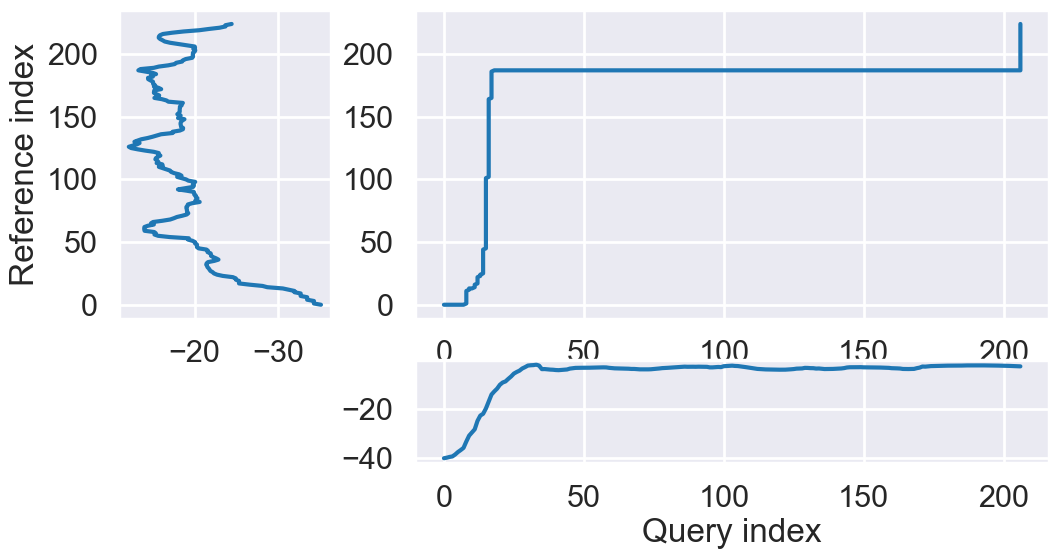

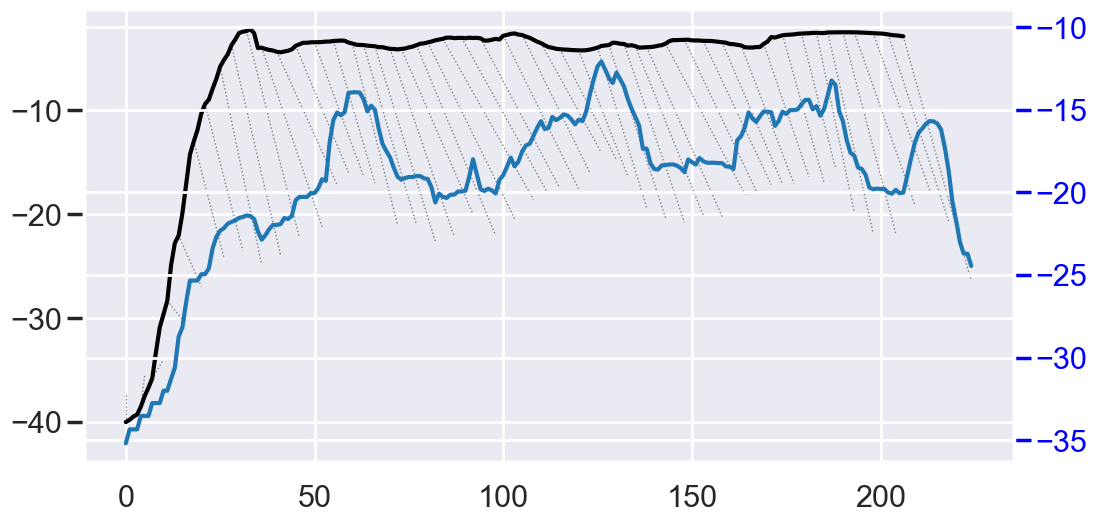

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



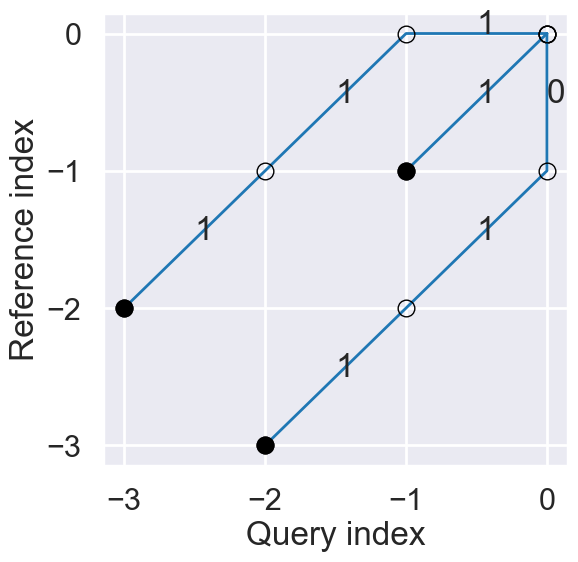

In [12]:
plt.figure()
d1,d2 = smooth_df(s1,s2,var='loudness_max')
dynamic_time_warping(d1,d2)

#### Loudness_max_time

The segment-relative offset of the segment peak loudness in seconds. Combined with loudness_start and loudness_max, these components can be used to describe the “attack” of the segment.


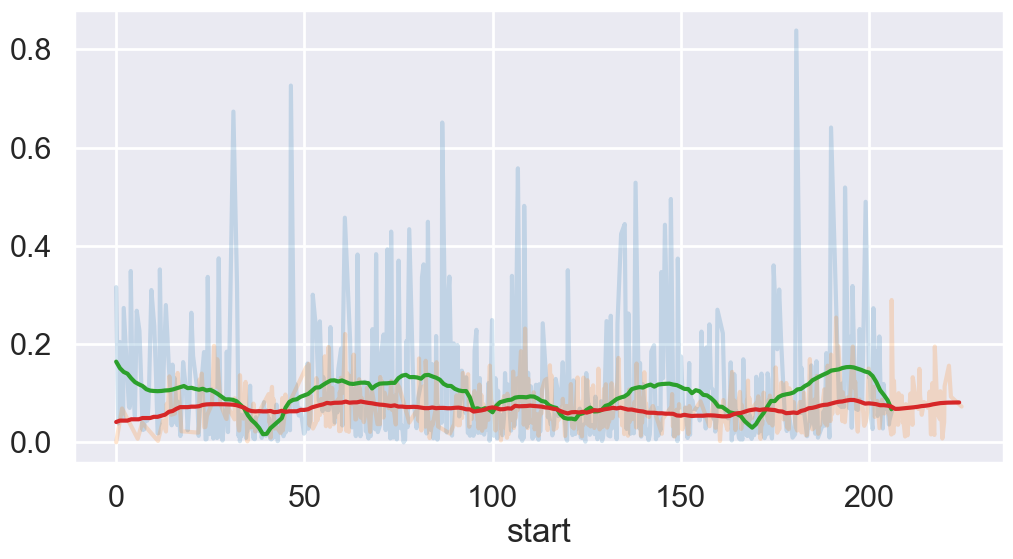

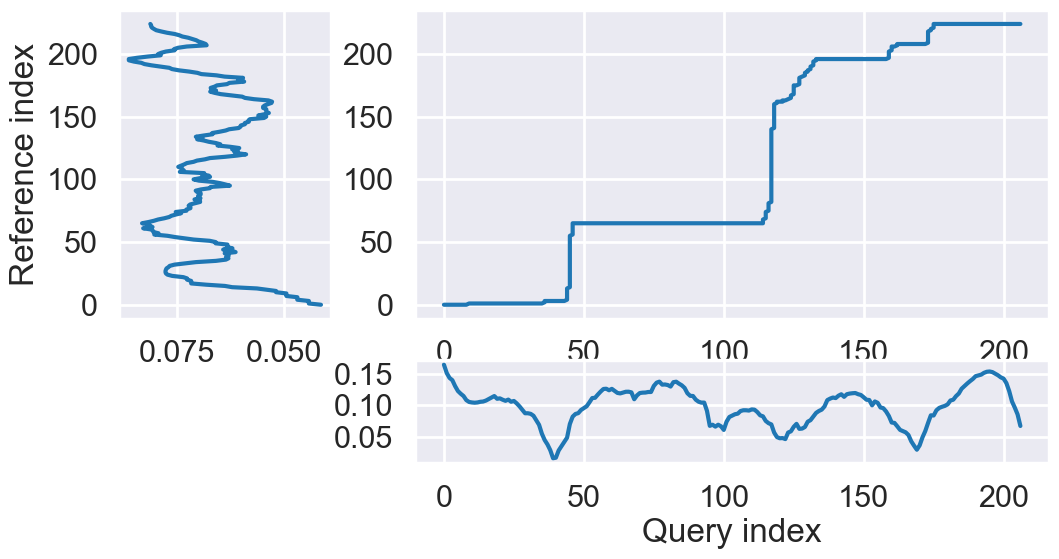

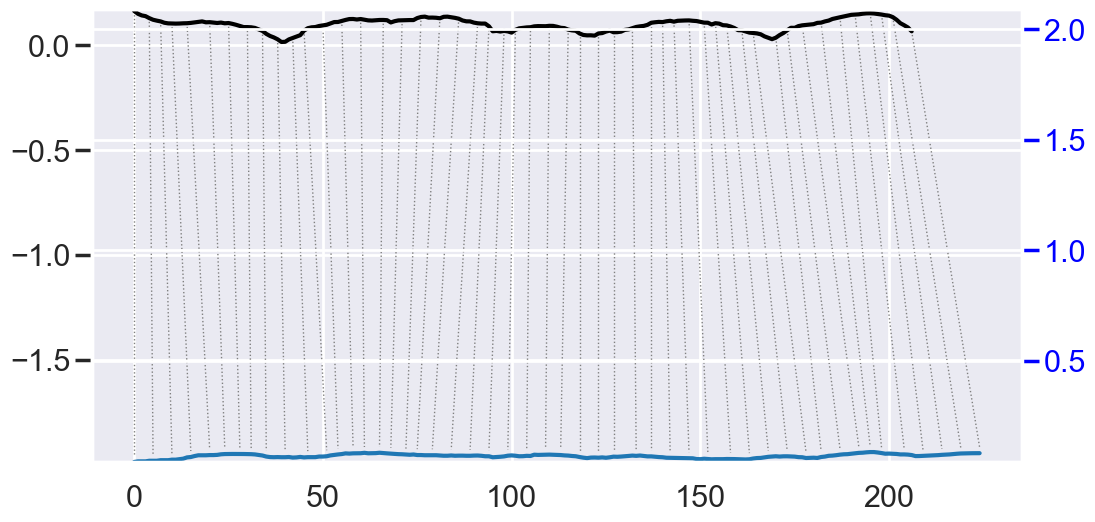

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



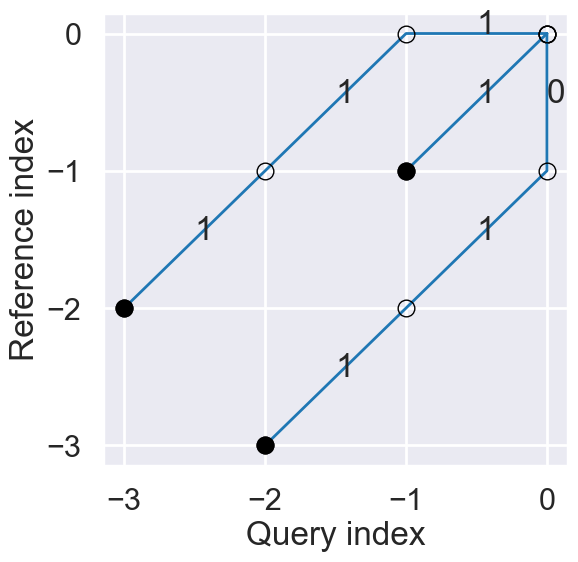

In [13]:
plt.figure()
d1,d2 = smooth_df(s1,s2,var='loudness_max_time')
dynamic_time_warping(d1,d2)

#### Loudness_end

The offset loudness of the segment in decibels (dB). This value should be equivalent to the loudness_start of the following segment.


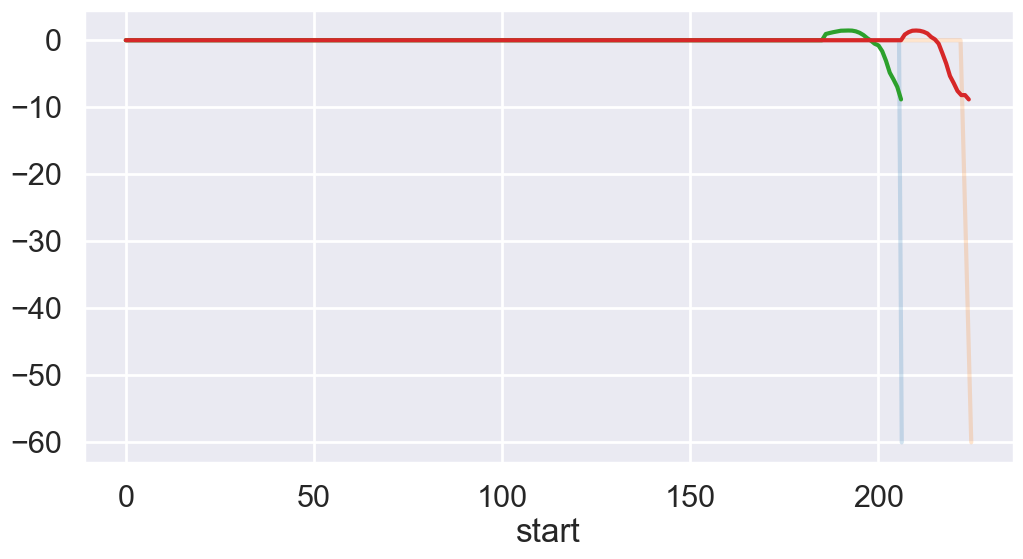

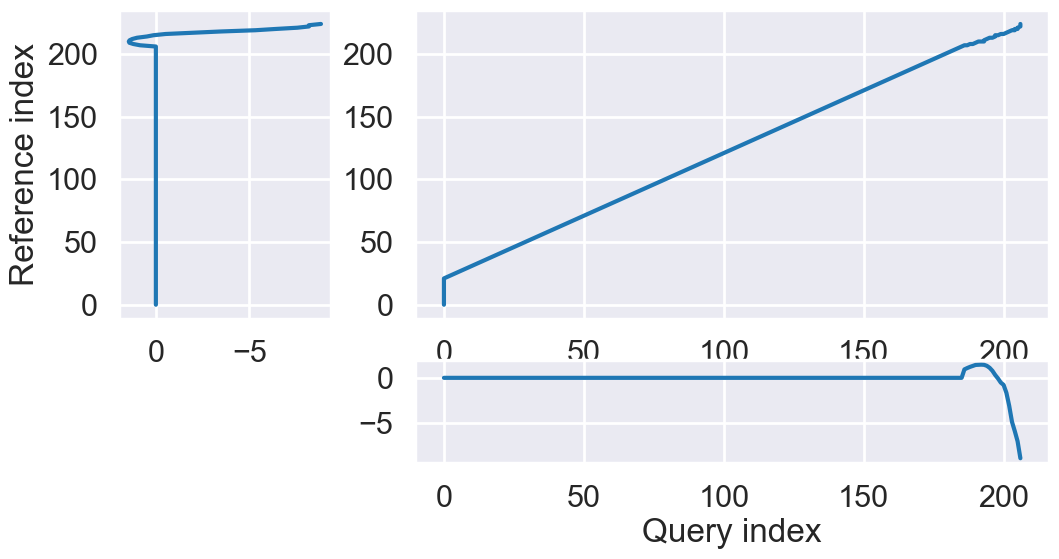

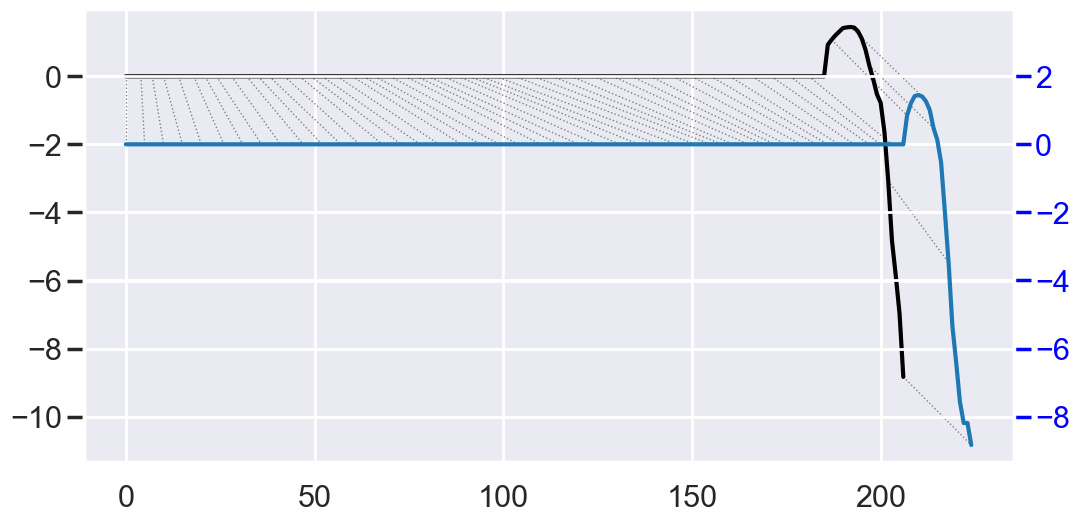

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



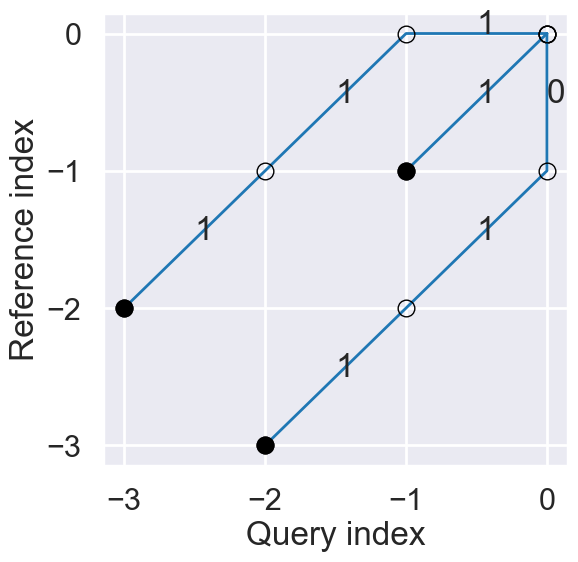

In [14]:
plt.figure()
d1,d2 = smooth_df(s1,s2,var='loudness_end')
dynamic_time_warping(d1,d2)

#### Pitches

A “chroma” vector representing the pitch content of the segment, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale.


In [30]:
#for p in pitches_nombre:
#    plt.plot(s2.index,savgol_filter(s1[p], window_length = 101, polyorder = 3))

#### Timbre

Timbre is the quality of a musical note or sound that distinguishes different types of musical instruments, or voices. Timbre vectors are best used in comparison with each other.


In [32]:
#for t in timbre_nombre:
#    plt.plot(s1.index,savgol_filter(s1[t], window_length = 101, polyorder = 3))
#plt.show()
#for t in timbre_nombre:
#    plt.plot(s2.index,savgol_filter(s2[t], window_length = 101, polyorder = 3))
